Image loaded successfully.
Number of masked pixels: 27159
Iteration 0, Loss: 1781.0909423828125
Iteration 100, Loss: 172.27847290039062
Iteration 200, Loss: 20.460439682006836
Iteration 300, Loss: 15.943359375
Iteration 400, Loss: 13.662086486816406
Iteration 500, Loss: 12.41401481628418
Iteration 600, Loss: 11.529206275939941
Iteration 700, Loss: 10.917831420898438
Iteration 800, Loss: 10.391408920288086
Iteration 900, Loss: 9.988192558288574


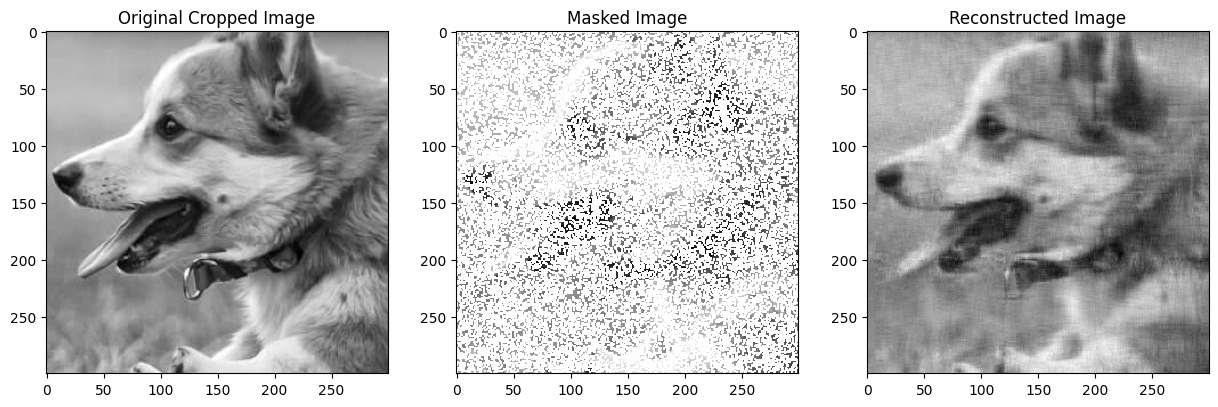

RMSE: 0.03858959674835205
PSNR: 28.27059555053711


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import torch.optim as optim

# Function to download an image if not already present
def download_image():
    import os
    if not os.path.exists('/content/dog.jpg'):
        !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg
    print("Image loaded successfully.")

# Function to mask a certain proportion of the image
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

# Matrix Factorization Function using Gradient Descent, ignoring NaN values
def factorize(A, k, num_iters=1000, lr=0.01, device=torch.device("cpu")):
    """Factorize the matrix A into W and H with gradient descent, ignoring NaN values."""
    A = A.to(device)

    # Randomly initialize W and H
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)

    # Optimizer
    optimizer = optim.Adam([W, H], lr=lr)

    # Mask to ignore NaN values
    mask = ~torch.isnan(A)

    # Train the model
    for i in range(num_iters):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    return W, H, loss

# Function to calculate RMSE
def calculate_rmse(original, reconstructed, mask):
    error = (original[mask] - reconstructed[mask]) ** 2
    return torch.sqrt(torch.mean(error)).item()

# Function to calculate PSNR
def calculate_psnr(original, reconstructed, mask):
    mse = torch.mean((original[mask] - reconstructed[mask]) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = torch.max(original[mask])
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr.item()

# Main Function for Image Loading, Masking, Factorization, and Plotting
def main():
    # Download image if not present
    download_image()

    # Read the image using torchvision
    img = torchvision.io.read_image("/content/dog.jpg").float() / 255.0  # Normalize image to [0, 1]
    img = img.mean(dim=0)  # Convert to grayscale by averaging RGB channels

    # Crop the image to a smaller size
    crop = F.crop(img, top=600, left=800, height=300, width=300)
    crop = crop.to('cuda')  # Move to GPU

    # Mask the cropped image
    masked_img, mask = mask_image(crop, 0.3)  # Mask 30% of the pixels
    print(f"Number of masked pixels: {mask.sum().item()}")

    # Perform matrix factorization to reconstruct the image
    rank = 50  # Set the rank for the factorization
    W, H, loss = factorize(masked_img, rank, num_iters=1000, lr=0.01, device='cuda')

    # Reconstruct the image
    reconstructed_img = torch.mm(W, H).cpu().detach().numpy()

    # Plot original cropped vs masked and reconstructed image
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(crop.cpu().numpy(), cmap='gray')
    ax[0].set_title('Original Cropped Image')
    ax[1].imshow(masked_img.cpu().numpy(), cmap='gray')
    ax[1].set_title('Masked Image')
    ax[2].imshow(reconstructed_img, cmap='gray')
    ax[2].set_title('Reconstructed Image')
    plt.show()

    # Calculate and display RMSE and PSNR
    masked_area = ~mask  # Inverted mask for non-NaN pixels
    rmse = calculate_rmse(crop, torch.tensor(reconstructed_img).to('cuda'), masked_area)
    psnr = calculate_psnr(crop, torch.tensor(reconstructed_img).to('cuda'), masked_area)

    print(f"RMSE: {rmse}")
    print(f"PSNR: {psnr}")

# Run the main function
if __name__ == "__main__":
    main()

Image loaded successfully.
Number of masked pixels: 900
Iteration 0, Loss: 2129.150634765625
Iteration 100, Loss: 198.27915954589844
Iteration 200, Loss: 24.803312301635742
Iteration 300, Loss: 19.744577407836914
Iteration 400, Loss: 17.22172737121582
Iteration 500, Loss: 15.424677848815918
Iteration 600, Loss: 14.275945663452148
Iteration 700, Loss: 13.591777801513672
Iteration 800, Loss: 13.07681655883789
Iteration 900, Loss: 12.664336204528809


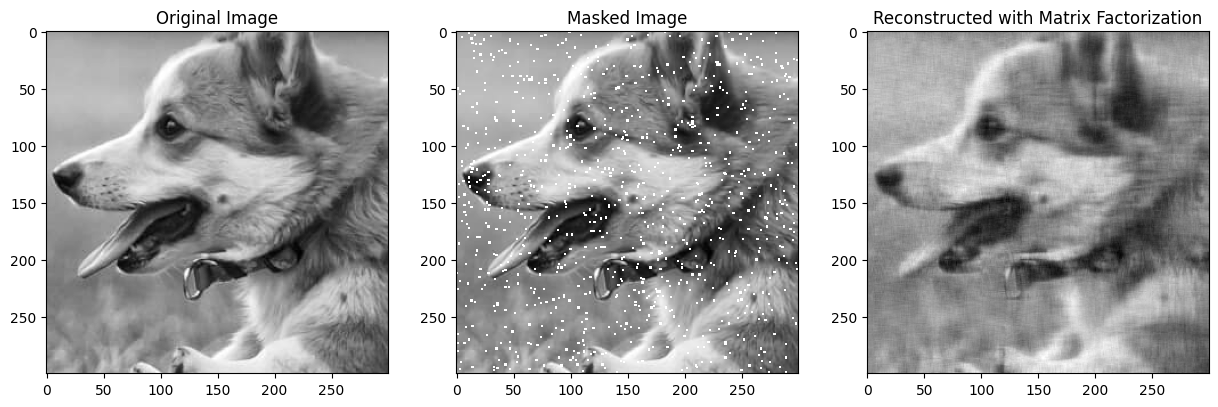

Matrix Factorization - RMSE: 0.04106574505567551, PSNR: 27.730405807495117


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import torch.optim as optim
import numpy as np

# Function to download an image if not already present
def download_image():
    import os
    if not os.path.exists('/content/dog.jpg'):
        !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg
    print("Image loaded successfully.")

# Function to randomly mask 900 pixels from the image
def mask_900_pixels(img):
    img_copy = img.clone()
    mask = torch.zeros_like(img_copy).bool()  # Create an all-false mask
    indices = torch.randperm(img_copy.numel())[:900]  # Randomly choose 900 indices
    mask.view(-1)[indices] = True  # Set the corresponding pixels to True
    img_copy[mask] = float('nan')  # Mask the chosen pixels
    return img_copy, mask

# Matrix Factorization Function using Gradient Descent
def factorize(A, k, num_iters=1000, lr=0.01, device=torch.device("cpu")):
    """Factorize the matrix A into W and H with gradient descent, ignoring NaN values."""
    A = A.to(device)

    # Randomly initialize W and H
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)

    # Optimizer
    optimizer = optim.Adam([W, H], lr=lr)

    # Mask to ignore NaN values
    mask = ~torch.isnan(A)

    # Train the model
    for i in range(num_iters):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    return W, H, loss

# Function to calculate RMSE
def calculate_rmse(original, reconstructed, mask):
    error = (original[mask] - reconstructed[mask]) ** 2
    return torch.sqrt(torch.mean(error)).item()

# Function to calculate PSNR
def calculate_psnr(original, reconstructed, mask):
    mse = torch.mean((original[mask] - reconstructed[mask]) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # Assuming normalized pixels [0, 1]
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr.item()

# Main Function for Image Loading, Masking, Factorization, and Plotting
def main():
    # Download image if not present
    download_image()

    # Read the image using torchvision
    img = torchvision.io.read_image("/content/dog.jpg").float() / 255.0  # Normalize image to [0, 1]
    img = img.mean(dim=0)  # Convert to grayscale by averaging RGB channels

    # Crop the image to a smaller size
    crop = F.crop(img, top=600, left=800, height=300, width=300)
    crop = crop.to('cuda')  # Move to GPU

    # Mask 900 random pixels
    masked_img, mask = mask_900_pixels(crop)
    print(f"Number of masked pixels: {mask.sum().item()}")

    # Perform matrix factorization to reconstruct the image
    rank = 50  # Set the rank for the factorization
    W, H, loss = factorize(masked_img, rank, num_iters=1000, lr=0.01, device='cuda')

    # Reconstruct the image using matrix factorization
    reconstructed_img_mf = torch.mm(W, H).cpu().detach().numpy()

    # Plot original, masked, and matrix factorized images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(crop.cpu().numpy(), cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(masked_img.cpu().numpy(), cmap='gray')
    ax[1].set_title('Masked Image')
    ax[2].imshow(reconstructed_img_mf, cmap='gray')
    ax[2].set_title('Reconstructed with Matrix Factorization')
    plt.show()

    # Calculate and display RMSE and PSNR
    masked_area = ~mask  # Inverted mask for non-NaN pixels
    rmse_mf = calculate_rmse(crop, torch.tensor(reconstructed_img_mf).to('cuda'), masked_area)
    psnr_mf = calculate_psnr(crop, torch.tensor(reconstructed_img_mf).to('cuda'), masked_area)

    print(f"Matrix Factorization - RMSE: {rmse_mf}, PSNR: {psnr_mf}")

# Run the main function
if __name__ == "__main__":
    main()


--2024-09-16 18:00:21--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.65.229.91, 18.65.229.20, 18.65.229.102, ...
Connecting to segment-anything.com (segment-anything.com)|18.65.229.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.02s   

2024-09-16 18:00:21 (8.83 MB/s) - ‘dog.jpg’ saved [221810/221810]

Image loaded successfully.
Number of masked pixels: 900


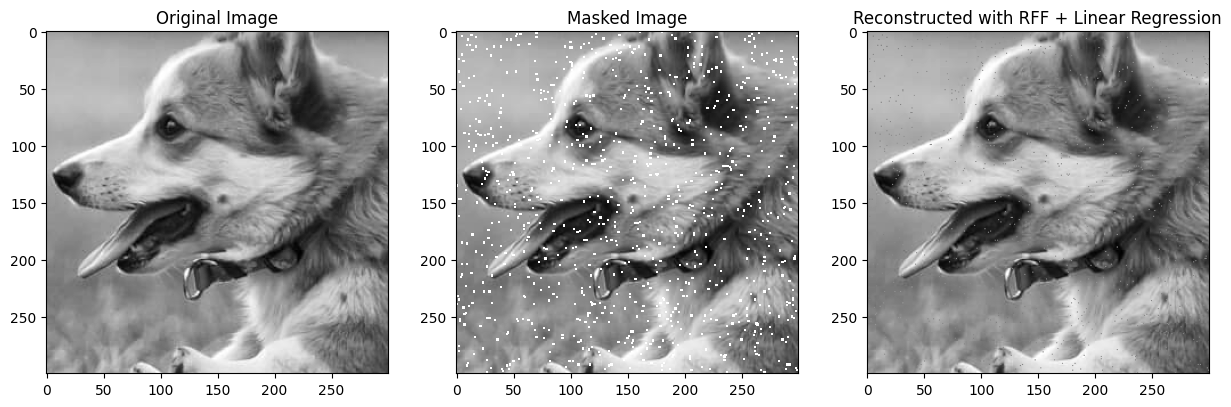

RFF + Linear Regression - RMSE: 0.0, PSNR: inf


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import RBFSampler

# Function to download an image if not already present
def download_image():
    import os
    if not os.path.exists('/content/dog.jpg'):
        !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg
    print("Image loaded successfully.")

# Function to randomly mask 900 pixels from the image
def mask_900_pixels(img):
    img_copy = img.clone()
    mask = torch.zeros_like(img_copy).bool()  # Create an all-false mask
    indices = torch.randperm(img_copy.numel())[:900]  # Randomly choose 900 indices
    mask.view(-1)[indices] = True  # Set the corresponding pixels to True
    img_copy[mask] = float('nan')  # Mask the chosen pixels
    return img_copy, mask

# Function to calculate RMSE
def calculate_rmse(original, reconstructed, mask):
    error = (original[mask] - reconstructed[mask]) ** 2
    return torch.sqrt(torch.mean(error)).item()

# Function to calculate PSNR
def calculate_psnr(original, reconstructed, mask):
    mse = torch.mean((original[mask] - reconstructed[mask]) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # Assuming normalized pixels [0, 1]
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr.item()

# Reconstruct using Random Fourier Features + Linear Regression
def reconstruct_with_rff(original, mask, num_features=500):
    """Reconstruct missing pixels using RFF and Linear Regression."""
    device = original.device  # Get the current device (GPU or CPU)

    # Get known and missing pixel coordinates
    X_known = torch.nonzero(~mask).cpu()  # Coordinates of known pixels, moved to CPU
    y_known = original[~mask].cpu().numpy()  # Known pixel values on CPU

    # Get missing pixel coordinates
    X_missing = torch.nonzero(mask).cpu()  # Coordinates of missing pixels on CPU

    # Create RFF transformer
    rbf_sampler = RBFSampler(n_components=num_features, random_state=42)

    # Transform the known and missing coordinates using RFF
    X_known_rff = rbf_sampler.fit_transform(X_known.numpy())
    X_missing_rff = rbf_sampler.transform(X_missing.numpy())

    # Fit Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_known_rff, y_known)

    # Predict the missing pixel values
    y_pred = lr_model.predict(X_missing_rff)

    # Reconstruct the image
    reconstructed_img = original.clone()
    reconstructed_img[mask] = torch.tensor(y_pred, dtype=torch.float32).to(device)  # Move prediction to original's device

    return reconstructed_img

# Main Function for Image Loading, Masking, RFF + Linear Regression, and Plotting
def main():
    # Download image if not present
    download_image()

    # Read the image using torchvision
    img = torchvision.io.read_image("/content/dog.jpg").float() / 255.0  # Normalize image to [0, 1]
    img = img.mean(dim=0)  # Convert to grayscale by averaging RGB channels

    # Crop the image to a smaller size
    crop = F.crop(img, top=600, left=800, height=300, width=300)
    crop = crop.to('cuda')  # Move to GPU

    # Mask 900 random pixels
    masked_img, mask = mask_900_pixels(crop)
    print(f"Number of masked pixels: {mask.sum().item()}")

    # Reconstruct the image using RFF and Linear Regression
    reconstructed_img_rff = reconstruct_with_rff(crop, mask)

    # Plot original, masked, and RFF reconstructed images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(crop.cpu().numpy(), cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(masked_img.cpu().numpy(), cmap='gray')
    ax[1].set_title('Masked Image')
    ax[2].imshow(reconstructed_img_rff.cpu().numpy(), cmap='gray')
    ax[2].set_title('Reconstructed with RFF + Linear Regression')
    plt.show()

    # Calculate and display RMSE and PSNR
    masked_area = ~mask  # Inverted mask for non-NaN pixels
    rmse_rff = calculate_rmse(crop, reconstructed_img_rff, masked_area)
    psnr_rff = calculate_psnr(crop, reconstructed_img_rff, masked_area)

    print(f"RFF + Linear Regression - RMSE: {rmse_rff}, PSNR: {psnr_rff}")

# Run the main function
if __name__ == "__main__":
    main()


Image loaded successfully.


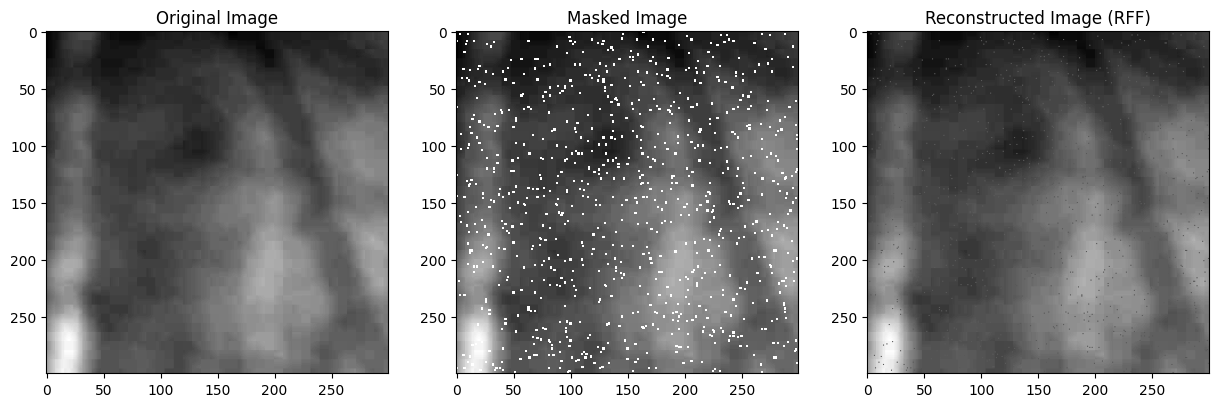

RMSE (RFF + Linear Regression): 0.043812744319438934
PSNR (RFF + Linear Regression): 27.16798973083496


In [ ]:
# import numpy as np
# from sklearn.linear_model import LinearRegression

# # Generate Random Fourier Features (RFF)
# def generate_rff(X, gamma=1.0, D=200):
#     n, d = X.shape
#     W = np.random.randn(d, D) * np.sqrt(2 * gamma)
#     b = np.random.uniform(0, 2 * np.pi, D)
#     Z = np.sqrt(2 / D) * np.cos(np.dot(X, W) + b)
#     return Z

# # Function to extract known pixel data
# def get_known_pixel_data(img, mask):
#     coords = torch.nonzero(~mask, as_tuple=False)
#     values = img[~mask]
#     return coords.cpu().numpy(), values.cpu().numpy()

# # Function to get the missing pixel data
# def get_missing_pixel_data(img, mask):
#     coords = torch.nonzero(mask, as_tuple=False)
#     return coords.cpu().numpy()

# # Function to apply linear regression using RFF
# def rff_linear_regression(X, y):
#     model = LinearRegression().fit(X, y)
#     return model

# # Reconstruct image using RFF + Linear Regression
# def reconstruct_with_rff(img, mask):
#     # Get known pixel data
#     X, y = get_known_pixel_data(img, mask)

#     # Generate RFF features
#     X_rff = generate_rff(X, gamma=1.0, D=200)

#     # Train a linear regression model
#     model = rff_linear_regression(X_rff, y)

#     # Predict missing pixels
#     missing_X = get_missing_pixel_data(img, mask)
#     missing_X_rff = generate_rff(missing_X, gamma=1.0, D=200)
#     missing_y_pred = model.predict(missing_X_rff)

#     # Reconstruct the image
#     reconstructed_img = img.clone()
#     reconstructed_img[mask] = torch.tensor(missing_y_pred).float().to('cuda')

#     return reconstructed_img

# # Main function for RFF reconstruction
# def rff_reconstruction():
#     # Download and process image
#     download_image()
#     img = torchvision.io.read_image("/content/dog.jpg").float() / 255.0
#     img = img.mean(dim=0)
#     img = img[:300, :300].to('cuda')

#     # Mask the image
#     img_masked, mask = mask_900_pixels(img)

#     # Reconstruct the image using RFF + Linear Regression
#     reconstructed_img = reconstruct_with_rff(img, mask)

#     # Calculate RMSE and PSNR
#     rmse = calculate_rmse(img, reconstructed_img, mask)
#     psnr = calculate_psnr(img, reconstructed_img, mask)

#     # Plot original, masked, and reconstructed images
#     fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#     ax[0].imshow(img.cpu(), cmap='gray')
#     ax[0].set_title('Original Image')
#     ax[1].imshow(img_masked.cpu(), cmap='gray')
#     ax[1].set_title('Masked Image')
#     ax[2].imshow(reconstructed_img.cpu(), cmap='gray')
#     ax[2].set_title('Reconstructed Image (RFF)')
#     plt.show()

#     print(f"RMSE (RFF + Linear Regression): {rmse}")
#     print(f"PSNR (RFF + Linear Regression): {psnr}")

# rff_reconstruction()
